**LightGBM, XGBoost and CatBoost - Tutorial Notebook / Competition Kernel (also my Medium Blog post)**

Gradient Boosted trees have become one of the most powerful algorithms for training on tabular data. Over the recent past, we’ve been fortunate to have may implementations of boosted trees – each with their own unique characteristics.
In this notebook, I will implement LightGBM, XGBoost and CatBoost to tackle this Kaggle problem.

**What is  Boosting**

To understand the absolute basics of the need for Boosting algorithm, lets ask a basic question - If a data point is incorrectly predicted by our first model, and then the next (probably all models), will combining the predictions provide better results? Such questions are handled by boosting algorithm.

So, Boosting is a sequential technique which works on the principle of an ensemble, where each subsequent model attempts to correct the errors of the previous model. The succeeding models are dependent on the previous model.

The basic principle behind the working of the boosting algorithm is to generate multiple weak learners and combine their predictions to form one strong rule. These weak rules are generated by applying base Machine Learning algorithms on different distributions of the data set. These algorithms generate weak rules for each iteration. After multiple iterations, the weak learners are combined to form a strong learner that will predict a more accurate outcome.
 Note that a weak learner is one which is slightly better than random guessing. For example, a decision tree whose predictions are slightly better than 50%.

 **Gradient Boosting** works by sequentially adding predictors to an ensemble, each one correcting its predecessor. However, instead of tweaking the instance weights at every iteration like AdaBoost does, this method tries to fit the new predictor to the residual errors made by the previous predictor.

**Here’s how the algorithm works**:

**Step 1**: The base algorithm reads the data and assigns equal weight to each sample observation.

**Step 2**: False predictions made by the base learner are identified. In the next iteration, these false predictions are assigned to the next base learner with a higher weightage on these incorrect predictions.

**Step 3**: Repeat step 2 until the algorithm can correctly classify the output.

Therefore, the main aim of Boosting is to focus more on miss-classified predictions.

![img](https://i.imgur.com/OpP7D0X.png)

[Source](https://catboost.ai/news/catboost-enables-fast-gradient-boosting-on-decision-trees-using-gpus)

These techniques are used to build ensemble models in an iterative way. On the first iteration, the algorithm learns the first tree to reduce the training error, shown on left-hand image above. The right-hand image above, shows the second iteration, in which the algorithm learns one more tree to reduce the error made by the first tree. The algorithm repeats this procedure until it builds a decent quality mode.

![img](https://i.imgur.com/OpP7D0X.png)

The common approach for classification uses Logloss while regression optimizes using root mean square error. Ranking tasks commonly implements some variation of LambdaRank.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn import preprocessing, model_selection, metrics
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor

from IPython.display import display # Allows the use of display() for DataFrames

import warnings
warnings.filterwarnings('ignore')

In [2]:
train_df = pd.read_csv('../input/santander-value-prediction-challenge/train.csv')

# Given the test.csv file is huge, reading which each time during development
# takes around 15 minutes - making my development process slower.
# I am reading only first 100 rows during development.
# test_df = pd.read_csv('../input/santander-value-prediction-challenge/test.csv', nrows=100)

# But in Kaggle Kernel, and before final submission
# comment-out the above line and un-comment below line to read the full train.csv
test_df = pd.read_csv('../input/santander-value-prediction-challenge/test.csv')

train_df.head()

,ID,target,48df886f9,0deb4b6a8,34b15f335,a8cb14b00,2f0771a37,30347e683,d08d1fbe3,6ee66e115,...,3ecc09859,9281abeea,8675bec0b,3a13ed79a,f677d4d13,71b203550,137efaa80,fb36b89d9,7e293fbaf,9fc776466
0,000d6aaf2,38000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
1,000fbd867,600000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
2,0027d6b71,10000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
3,0028cbf45,2000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
4,002a68644,14400000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0


In [3]:
test_df.head()

,ID,48df886f9,0deb4b6a8,34b15f335,a8cb14b00,2f0771a37,30347e683,d08d1fbe3,6ee66e115,20aa07010,...,3ecc09859,9281abeea,8675bec0b,3a13ed79a,f677d4d13,71b203550,137efaa80,fb36b89d9,7e293fbaf,9fc776466
0,000137c73,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00021489f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0004d7953,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00056a333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,00056d8eb,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4459 entries, 0 to 4458
Columns: 4993 entries, ID to 9fc776466
dtypes: float64(1845), int64(3147), object(1)
memory usage: 169.9+ MB


Initial Observations looking at the above data

- Column name does not mean anything now, as they are all anonymized
- The dataframe is full of zero values.
- The dataset is a sparse tabular one refer [this](https://www.kaggle.com/c/santander-value-prediction-challenge/discussion/59128)

Target Variable:

First doing some scatter plot of the target variable to check for visible outliers.

In [5]:
print('Train rows and columns: ', train_df.shape)

# Keeping below line commented out as its huge 49,342 row file with 1gb size and so take longer to run each time
print('Test rows and columns: ', test_df.shape)

Train rows and columns:  (4459, 4993)
Test rows and columns:  (49342, 4992)


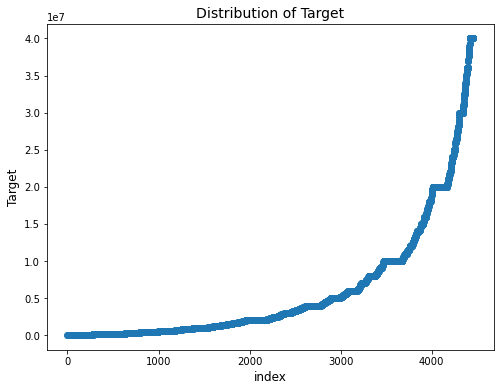

In [6]:
# Keeping below lines commented out during development

plt.figure(figsize=(8,6))
plt.scatter(range(train_df.shape[0]), np.sort(train_df['target'].values))
plt.xlabel('index', fontsize=12)
plt.ylabel('Target', fontsize=12)
plt.title('Distribution of Target', fontsize=14)
plt.show()

TO-DO - So there's not too much of outliers (visibly) but the distribution range is high. Now want to do a histogram

## Checking for missing / null values in data

In [7]:
print("All Features in Train data with NaN Values =", str(train_df.columns[train_df.isnull().sum() != 0].size) )
# print("All Features in Test data with NaN Values =", str(test_df.columns[train_df.isnull().sum() != 0].size) )

All Features in Train data with NaN Values = 0


## Remove constant columns from data

In [8]:
const_columns_to_remove = []
for col in train_df.columns:
    if col != 'ID' and col != 'target':
        if train_df[col].std() == 0:
            const_columns_to_remove.append(col)

# Now remove that array of const columns from the data
train_df.drop(const_columns_to_remove, axis=1, inplace=True)
test_df.drop(const_columns_to_remove, axis=1, inplace=True)

# Print to see the reduction of columns
print('train_df rows and columns after removing constant columns: ', train_df.shape)

print('Following `{}` Constant Column\n are removed'.format(len(const_columns_to_remove)))
print(const_columns_to_remove)

train_df rows and columns after removing constant columns:  (4459, 4737)
Following `256` Constant Column
 are removed
['d5308d8bc', 'c330f1a67', 'eeac16933', '7df8788e8', '5b91580ee', '6f29fbbc7', '46dafc868', 'ae41a98b6', 'f416800e9', '6d07828ca', '7ac332a1d', '70ee7950a', '833b35a7c', '2f9969eab', '8b1372217', '68322788b', '2288ac1a6', 'dc7f76962', '467044c26', '39ebfbfd9', '9a5ff8c23', 'f6fac27c8', '664e2800e', 'ae28689a2', 'd87dcac58', '4065efbb6', 'f944d9d43', 'c2c4491d5', 'a4346e2e2', '1af366d4f', 'cfff5b7c8', 'da215e99e', '5acd26139', '9be9c6cef', '1210d0271', '21b0a54cb', 'da35e792b', '754c502dd', '0b346adbd', '0f196b049', 'b603ed95d', '2a50e001c', '1e81432e7', '10350ea43', '3c7c7e24c', '7585fce2a', '64d036163', 'f25d9935c', 'd98484125', '95c85e227', '9a5273600', '746cdb817', '6377a6293', '7d944fb0c', '87eb21c50', '5ea313a8c', '0987a65a1', '2fb7c2443', 'f5dde409b', '1ae50d4c3', '2b21cd7d8', '0db8a9272', '804d8b55b', '76f135fa6', '7d7182143', 'f88e61ae6', '378ed28e0', 'ca4ba131e

## Remove Duplicate Columns

**I will be using the duplicated() function of pandas - here's how it works:**

Suppose the columns of the data frame are `['alpha','beta','alpha']`

`df.columns.duplicated()` returns a boolean array: a `True` or `False` for each column. If it is `False` then the column name is unique up to that point, if it is `True` then the column name is duplicated earlier. For example, using the given example, the returned value would be `[False,False,True]`. 

`Pandas` allows one to index using boolean values whereby it selects only the `True` values. Since we want to keep the unduplicated columns, we need the above boolean array to be flipped (ie `[True, True, False] = ~[False,False,True]`)

Finally, `df.loc[:,[True,True,False]]` selects only the non-duplicated columns using the aforementioned indexing capability. 

**Note**: the above only checks columns names, *not* column values.

In [9]:
train_df = train_df.loc[:,~train_df.columns.duplicated()]
print('Train rows and columns after removing duplicate columns: ', train_df.shape)

Train rows and columns after removing duplicate columns:  (4459, 4737)


## Handling Sparse data

**What is Sparse data**

As an example, let's say that we are collecting data from a device which has 12 sensors. And you have collected data for 10 days.

The data you have collected is as follows:

[![enter image description here][1]][1]


The above is an example of sparse data because most of the sensor outputs are zero. Which means those sensors are functioning properly but the actual reading is zero. Although this matrix has high dimensional data (12 axises) it can be said that it contains less information.

So basically, sparse data means that there are many gaps present in the data being recorded. For example, in the case of the sensor mentioned above, the sensor may send a signal only when the state changes, like when there is a movement of the door in a room. This data will be obtained intermittently because the door is not always moving. Hence, this is sparse data.

  [1]: https://i.stack.imgur.com/Af5IH.png


First lets have a look at or train_df data again, that how much of sparse data is there. And as we can see there are plenty of '0'

In [10]:
train_df.head()

,ID,target,48df886f9,0deb4b6a8,34b15f335,a8cb14b00,2f0771a37,30347e683,d08d1fbe3,6ee66e115,...,3ecc09859,9281abeea,8675bec0b,3a13ed79a,f677d4d13,71b203550,137efaa80,fb36b89d9,7e293fbaf,9fc776466
0,000d6aaf2,38000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
1,000fbd867,600000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
2,0027d6b71,10000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
3,0028cbf45,2000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
4,002a68644,14400000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0


## Check and handle total memory of data

`get_dummies` pandas function converts categorical variables into indicator variables.

In [11]:
def print_memory_usage_of_df(df):
    bytes_per_mb = 0.000001
    memory_usage = round(df.memory_usage().sum() * bytes_per_mb, 3)
    print('Memory usage is ', str(memory_usage) + " MB")

print_memory_usage_of_df(train_df)
print(train_df.shape)

Memory usage is  168.978 MB
(4459, 4737)


In [12]:
dummy_encoded_train_df = pd.get_dummies(train_df)
dummy_encoded_train_df.shape

(4459, 9195)

In [13]:
print_memory_usage_of_df(dummy_encoded_train_df)

Memory usage is  188.825 MB


We see that the memory usage of the dummy_encoded_train_df data  frame is larger compared to the original, because now the number of columns have increased in the data frame.

##### So lets apply `sparse=True` if it reduces the memory-usages to some extent.

This parameter `sparse` defaults to False. If True the encoded columns are returned as **SparseArray**. By setting `sparse=True` we create a sparse data frame directly

In [14]:
dummy_encoded_sparse_train_df = pd.get_dummies(train_df, sparse=True)
dummy_encoded_sparse_train_df.shape

(4459, 9195)

In [15]:
print_memory_usage_of_df(dummy_encoded_sparse_train_df)


Memory usage is  168.965 MB


But looks like in this case the reduction in memory_size was not a huge amount. So lets try some other alternative

## [Pandas Sparse Structures](https://pandas.pydata.org/pandas-docs/stable/user_guide/sparse.html#sparse-data-structures)

Pandas provides data structures for efficient storage of sparse data. In these structures, zero values (or any other specified value) are not actually stored in the array. Rather, you can view these objects as being “compressed” where any data matching a specific value (NaN / missing value, though any value can be chosen, including 0) is omitted. The compressed values are not actually stored in the array.

Storing only the non-zero values and their positions is a common technique in storing sparse data sets.

This hugely reduces the memory usage of our data set and “compress” the data frame.

In our example, we will convert the one-hot encoded columns into SparseArrays, which are 1-d arrays where only non-zero values are stored.

In [16]:
def convert_df_to_sparse_array(df, exclude_columns=[]):
    df = df.copy()
    exclude_columns = set(exclude_columns)

    for (column_name, column_data) in df.iteritems():
        if column_name in exclude_columns:
            continue
        df[column_name] = pd.SparseArray(column_data.values, dtype='uint8')

    return df

# Now convert our earlier dummy_encoded_train_df with above function and check memory_size

# train_data_post_conversion_to_sparse_array = convert_df_to_sparse_array(dummy_encoded_train_df)
# print('Sparse Array Train_DF rows and columns: ', train_data_post_conversion_to_sparse_array.shape)
# print_memory_usage_of_df(train_data_post_conversion_to_sparse_array)

# Commenting the above out - for running the Notebook faster during my development 
# Because df.iteritems() will take a huge time to process the data - see warning below

**We see the that the memory_usage is substantially reduced now**

### A warning on using df.iteritems()

The df.iteritems() iterates over columns and not rows. Generally iteration over dataframes is an anti-pattern, and something we should avoid, unless you want to get used to a lot of waiting.

## Sparse Data Removal (Following simpler plain-vanilla technique)

### For this notebook, I will go with the easier approach to handle sparse data - which is just to drop it from the dataframe

like below code, I will do this for the sake of running this notebook faster for now


In [17]:
def drop_sparse_from_train_test(train, test):
    column_list_to_drop_data_from = [x for x in train.columns if not x in ['ID','target']]
    for f in column_list_to_drop_data_from:
        if len(np.unique(train[f]))<2:
            train.drop(f, axis=1, inplace=True)
            test.drop(f, axis=1, inplace=True)
    return train, test

train_df, test_df = drop_sparse_from_train_test(train_df, test_df)


### Split data into Train and Test for Model Training

In [18]:
X_train = train_df.drop(['ID', 'target'], axis=1)

y_train = np.log1p(train_df['target'].values)

X_test_original = test_df.drop('ID', axis=1)

X_train_split, X_validation, y_train_split, y_validation = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

## LightGBM Model Training

### Fundamentals of LightGBM Model

It is a **gradient boosting** model that makes use of tree based learning algorithms. It is considered to be a fast processing algorithm.

While other algorithms trees grow horizontally, LightGBM algorithm grows vertically, meaning it grows leaf-wise and other algorithms grow level-wise. LightGBM chooses the leaf with large loss to grow. It can lower down more loss than a level wise algorithm when growing the same leaf.

![img](https://i.imgur.com/pzOP2Lb.png)

[Source of Image](https://www.analyticsvidhya.com/blog/2017/06/which-algorithm-takes-the-crown-light-gbm-vs-xgboost/)

Light GBM is prefixed as Light because of its high speed. Light GBM can handle the large size of data and takes lower memory to run.

Another reason why Light GBM is so popular is because it focuses on accuracy of results. LGBM also supports GPU learning and thus data scientists are widely using LGBM for data science application development.

**Leaf growth technique in LightGBM**

LightGBM uses leaf-wise (best-first) tree growth. It chooses to grow the leaf that minimizes the loss, allowing a growth of an imbalanced tree. Because it doesn’t grow level-wise, but leaf-wise, over-fitting can happen when data is small. In these cases, it is important to control the tree depth.

### When to use LightGBM ?

LightGBM is not preferred for a small volume of datasets as it can easily overfit small data due to its sensitivity. Hence, it generally advised for data having more than 10,000+ rows, though there is no fixed threshold that helps in deciding the usage of LightGBM.

## What are LightGBM Parameters?

While, LightGBM has more than 100 parameters that are given in the [documentation of LightGBM](https://github.com/microsoft/LightGBM), let's checkout the most important ones.

#### Control Parameters

**Max depth**: It gives the depth of the tree and also controls the overfitting of the model. If you feel your model is getting overfitted lower down the max depth.

**Min_data_in_leaf**: Leaf minimum number of records also used for controlling overfitting of the model.

**Feature_fraction**: It decides the randomly chosen parameter in every iteration for building trees. If it is 0.7 then it means 70% of the parameter would be used.

**Bagging_fraction**: It checks for the data fraction that will be used in every iteration. Often, used to increase the training speed and avoid overfitting.

**Early_stopping_round**: If the metric of the validation data does show any improvement in last early_stopping_round rounds. It will lower the imprudent iterations.

**Lambda**: It states regularization. Its values range from 0 to 1.

**Min_gain_to_split**: Used to control the number of splits in the tree.

### Core Parameters

**Task**: It tells about the task that is to be performed on the data. It can either train on the data or prediction on the data.

**Application**: This parameter specifies whether to do regression or classification. LightGBM default parameter for application is regression.

**Binary**: It is used for binary classification.

**Multiclass**: It is used for multiclass classification problems.

**Regression**: It is used for doing regression.

**Boosting**: It specifies the algorithm type.

**rf** :  Used for Random Forest.

**Goss**: Gradient-based One Side Sampling.

**Num_boost_round**: It tells about the boosting iterations.

**Learning_rate**: The role of learning rate is to power the magnitude of the changes in the approximate that gets updated from each tree’s output. It determines the contribution of each tree on the final outcome and controls how quickly the algorithm proceeds down the gradient descent (learns); Typical values between 0.001–0.3. Smaller values make the model robust to the specific characteristics of each individual tree, thus allowing it to generalize well. Smaller values also make it easier to stop prior to overfitting; however, they increase the risk of not reaching the optimum with a fixed number of trees and are more computationally demanding. This hyperparameter is also called shrinkage. Generally, the smaller this value, the more accurate the model can be but also will require more trees in the sequence.

**Num_leaves**: It gives the total number of leaves that would be present in a full tree, default value: 31

### Metric Parameter

It takes care of the loss while building the model. Some of them are stated below for classification as well as regression.

**Mae**: Mean absolute error.

**Mse**: Mean squared error.

**Binary_logloss**: Binary Classification loss.

**Multi_logloss**: Multi Classification loss.

In [19]:
def light_gbm_model_run(train_x, train_y, validation_x, validation_y, test_x):
    params = {
        "objective" : "regression",
        "metric" : "rmse",
        "num_leaves" : 100,
        "learning_rate" : 0.001,
        "bagging_fraction" : 0.6,
        "feature_fraction" : 0.6,
        "bagging_frequency" : 6,
        "bagging_seed" : 42,
        "verbosity" : -1,
        "seed": 42
    }
    # Given its a regression case, I am using the RMSE as the metric.

    lg_train = lgb.Dataset(train_x, label=train_y)
    lg_validation = lgb.Dataset(validation_x, label=validation_y)
    evals_result_lgbm = {}

    model_light_gbm = lgb.train(params, lg_train, 5000,
                      valid_sets=[lg_train, lg_validation],
                      early_stopping_rounds=100,
                      verbose_eval=150,
                      evals_result=evals_result_lgbm )

    pred_test_light_gbm = np.expm1(model_light_gbm.predict(test_x, num_iteration=model_light_gbm.best_iteration ))

    return pred_test_light_gbm, model_light_gbm, evals_result_lgbm

In [20]:
# Training and output of LightGBM Model
predictions_test_y_light_gbm, model_lgbm, evals_result = light_gbm_model_run(X_train_split, y_train_split, X_validation, y_validation, X_test_original)
print('Output of LightGBM Model training..')

Training until validation scores don't improve for 100 rounds
[150]	training's rmse: 1.66447	valid_1's rmse: 1.63996
[300]	training's rmse: 1.5765	valid_1's rmse: 1.5927
[450]	training's rmse: 1.49849	valid_1's rmse: 1.55466
[600]	training's rmse: 1.42919	valid_1's rmse: 1.52339
[750]	training's rmse: 1.36631	valid_1's rmse: 1.49837
[900]	training's rmse: 1.30931	valid_1's rmse: 1.47791
[1050]	training's rmse: 1.25734	valid_1's rmse: 1.46143
[1200]	training's rmse: 1.20984	valid_1's rmse: 1.44818
[1350]	training's rmse: 1.16678	valid_1's rmse: 1.43796
[1500]	training's rmse: 1.12698	valid_1's rmse: 1.42969
[1650]	training's rmse: 1.09049	valid_1's rmse: 1.42292
[1800]	training's rmse: 1.05661	valid_1's rmse: 1.41849
[1950]	training's rmse: 1.02528	valid_1's rmse: 1.41488
[2100]	training's rmse: 0.995869	valid_1's rmse: 1.41222
[2250]	training's rmse: 0.968211	valid_1's rmse: 1.40996
[2400]	training's rmse: 0.941985	valid_1's rmse: 1.40807
[2550]	training's rmse: 0.917269	valid_1's rmse


## Hyper-Parameter Tuning in LightGBM

Parameter Tuning is an important part that is usually done by data scientists to achieve a good accuracy, fast result and to deal with overfitting. Let us see quickly some of the parameter tuning you can do for better results.

**num_leaves**: This parameter is responsible for the complexity of the model. I normally start by trying values in the range [10,100]. But if you have a solid heuristic to choose tree depth you can always use it and set num_leaves to 2^tree_depth - 1

[LightGBM Documentation](https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html) says in respect -
This is the main parameter to control the complexity of the tree model. Theoretically, we can set num_leaves = 2^(max_depth) to obtain the same number of leaves as depth-wise tree. However, this simple conversion is not good in practice. The reason is that a leaf-wise tree is typically much deeper than a depth-wise tree for a fixed number of leaves. Unconstrained depth can induce over-fitting. Thus, when trying to tune the num_leaves, we should let it be smaller than 2^(max_depth). For example, when the max_depth=7 the depth-wise tree can get good accuracy, but setting num_leaves to 127 may cause over-fitting, and setting it to 70 or 80 may get better accuracy than depth-wise.

**Min_data_in_leaf**: Assigning bigger value to this parameter can result in underfitting of the model. Giving it a value of 100 or 1000 is sufficient for a large dataset.

**Max_depth**: Controls the depth of the individual trees. Typical values range from a depth of 3–8 but it is not uncommon to see a tree depth of 1. Smaller depth trees are computationally efficient (but require more trees); however, higher depth trees allow the algorithm to capture unique interactions but also increase the risk of over-fitting. Larger training data sets are more tolerable to deeper trees.

**num_iterations**: Num_iterations specifies the number of boosting iterations (trees to build). The more trees you build the more accurate your model can be at the cost of:
    - Longer training time
    - Higher chance of over-fitting
So typically start with a lower number of trees to build a baseline and increase it later when you want to squeeze the last % out of your model.

It is recommended to use smaller `learning_rate` with larger `num_iterations`. Also, we should use `early_stopping_rounds` if we go for higher `num_iterations` to stop your training when it is not learning anything useful.

**early_stopping_rounds** - "early stopping" refers to stopping the training process if the model's performance on a given validation set does not improve for several consecutive iterations. This parameter will stop training if the validation metric is not improving after the last early stopping round. It should be defined in pair with a number of iterations. If we set it too large we increase the chance of over-fitting. **The rule of thumb is to have it at 10% of your `num_iterations`**.


#### So for my above implementation of LightGBM, initially for two of the LightGBM parameters as below got me a score of 1.47953 (in Kaggle Public Board)

```
"num_leaves" : 40,
"learning_rate" : 0.004,
```

And now if I only tune these parameters as below

```
"num_leaves" : 100,
"learning_rate" : 0.001,
```
#### I got my score very very slightly updated to 1.4714 (in Kaggle Public Board)

I also tried the below one (keeping 'num_leaves' at 70 to avoid over-fitting)

```
"num_leaves" : 70,
"learning_rate" : 0.001,
```
With this - I got a score of 1.47234 (in Kaggle Public Board)

## Features Importance in LightGBM

In [21]:
gain_light_gbm = model_lgbm.feature_importance('gain')
feature_imp_light_gbm = pd.DataFrame({'feature': model_lgbm.feature_name(),
                                      'split': model_lgbm.feature_importance('split'),
                                      'gain': 100 * gain_light_gbm / gain_light_gbm.sum()
}).sort_values('gain', ascending=False)
print(feature_imp_light_gbm[:50])

        feature  split      gain
4135  f190486d6   6623  6.950093
2378  58e2e02e6   6012  4.948486
3470  eeb9cd3aa   5474  4.035842
2617  9fd594eec   4157  3.262016
4025  15ace8c9f   5198  2.999663
8     20aa07010   3628  1.903282
3576  58232a6fb   3458  1.472419
834   6eef030c1   3798  1.292199
1459  b43a7cfd5   4241  1.255624
2690  fb0f5dbfe   4482  1.118876
3666  491b9ee45   2625  1.040685
1484  024c577b9   2931  1.027777
4348  1702b5bf0   2993  0.934598
4190  f74e8f13d   3636  0.931987
566   66ace2992   3053  0.899695
4513  c47340d97   3209  0.888001
3727  d6bb78916   3296  0.863508
2082  58e056e12   3651  0.859513
863   fc99f9426   2474  0.778488
3816  adb64ff71   2664  0.749633
4458  190db8488   3040  0.721582
4033  5c6487af1   2454  0.703383
3224  ced6a7e91   1666  0.667195
3796  ed8ff54b5    737  0.643995
2137  241f0f867   2467  0.641655
537   26fc93eb7   2559  0.620171
3872  2288333b4   1182  0.614189
3891  50e4f96cf   1147  0.594101
2619  fb387ea33    998  0.583353
828   6786

## XGBoost Model Training

### Note on XGBoost

Below we will be using **XGBoost** which is an advanced version of Gradient boosting method, it literally means eXtreme Gradient Boosting. XGBoost dominates structured or tabular datasets on classification and regression predictive modeling problems. The XGBoost library implements the [gradient boosting decision tree algorithm](https://en.wikipedia.org/wiki/Gradient_boosting).

Different from the traditional gradient descent technique, gradient enhancement helps to predict the optimal gradient of the additional model. This technique can reduce the output error at each iteration.

In practice what we do in order to build the learner is to:

- Start with single root (contains all the training examples)

- Iterate over all features and values per feature, and evaluate each possible split loss reduction:

- gain = loss(father instances) - (loss(left branch)+loss(right branch))

- The gain for the best split must be positive (and > min_split_gain parameter), otherwise we must stop growing the branch.

**Leaf growth**

XGboost splits up to the specified max_depth hyperparameter and then starts pruning the tree backwards and removes splits beyond which there is no positive gain. It uses this approach since sometimes a split of no loss reduction may be followed by a split with loss reduction. XGBoost can also perform leaf-wise tree growth (as LightGBM).

Normally it is impossible to enumerate all the possible tree structures q. A greedy algorithm that starts from a single leaf and iteratively adds branches to the tree is used instead. Assume that I_L and I_R are the instance sets of left and right nodes after the split. Then the loss reduction after the split is given by,

![](https://i.imgur.com/jzyLh81.png)

## Differences in LightGBM & XGBoost

LightGBM uses a novel technique of Gradient-based One-Side Sampling (GOSS) to filter out the data instances for finding a split value while XGBoost uses pre-sorted algorithm & Histogram-based algorithm for computing the best split. Here instances mean observations/samples.

Let's see how pre-sorting splitting works-

- For each node, enumerate over all features

- For each feature, sort the instances by feature value

- Use a linear scan to decide the best split along that feature basis information gain

- Take the best split solution along all the features

In simple terms, Histogram-based algorithm splits all the data points for a feature into discrete bins and uses these bins to find the split value of histogram. While, it is efficient than pre-sorted algorithm in training speed which enumerates all possible split points on the pre-sorted feature values, it is still behind GOSS in terms of speed.

## XGBoost Model Parameters

I am explaining only those Parameters that I will be implementing below in my function. For an exhaustive explanation of all of them [see here](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/)

**objective [default=reg:linear]**

This defines the loss function to be minimized. Mostly used values are:

- binary:logistic –logistic regression for binary classification, returns predicted probability (not class)

- multi:softmax –multiclass classification using the softmax objective, returns predicted class (not probabilities)
you also need to set an additional num_class (number of classes) parameter defining the number of unique classes

- multi:softprob –same as softmax, but returns predicted probability of each data point belonging to each class.

**eval_metric [ default according to objective ]**

The metric to be used for validation data. The default values are rmse for regression and error for classification.
Typical values are:

- rmse – root mean square error

- mae – mean absolute error

- logloss – negative log-likelihood

- error – Binary classification error rate (0.5 threshold)

- merror – Multiclass classification error rate

- mlogloss – Multiclass logloss

- auc: Area under the curve


**eta [default=0.3]**

- Analogous to learning rate in GBM.
- Makes the model more robust by shrinking the weights on each step.
- Typical final values to be used: 0.01-0.2

**colsample_bytree**:  We can create a random sample of the features (or columns) to use prior to creating each decision tree in the boosted model. That is, tuning Column Sub-sampling in XGBoost By Tree. This is controlled by the colsample_bytree parameter. The default value is 1.0 meaning that all columns are used in each decision tree. A fraction (e.g. 0.6) means a fraction of columns to be subsampled. We can evaluate values for colsample_bytree between 0.1 and 1.0 incrementing by 0.1.

#### A Note on regularization in XGBoost

XGBoost adds built-in regularization to achieve accuracy gains beyond gradient boosting. Regularization is the process of adding information to reduce variance and prevent overfitting.

Although data may be regularized through hyperparameter fine-tuning, regularized algorithms may also be attempted. For example, Ridge and Lasso are regularized machine learning alternatives to LinearRegression.

XGBoost includes regularization as part of the learning objective, as contrasted with gradient boosting and random forests. The regularized parameters penalize complexity and smooth out the final weights to prevent overfitting. XGBoost is a regularized version of gradient boosting.

Mathematically, XGBoost's learning objective may be defined as follows:

### obj(θ) = l(θ) + Ω (θ)

Here, **l(θ)**  is the loss function, which is the Mean Squared Error (MSE) for regression, or the log loss for classification, and **Ω (θ)** is the regularization function, a penalty term to prevent over-fitting. Including a regularization term as part of the objective function distinguishes XGBoost from most tree ensembles.

The learning objective for the th boosted tree can now be rewritten as follows:

![img](https://i.imgur.com/IRNCrvM.png)

**reg_alpha and reg_lambda** : First note the loss function is defined as

![img](https://i.imgur.com/aw1Hod9.png)

##### So the above is how the regularized objective function looks like if you want to allow for the inclusion of a L1 and a L2 parameter in the same model

`reg_alpha` and `reg_lambda` control the L1 and L2 regularization terms, which in this case limit how extreme the weights at the leaves can become. Higher values of alpha mean more L1 regularization. See the documentation [here](http://xgboost.readthedocs.io/en/latest///parameter.html#parameters-for-tree-booster).

Since L1 regularization in GBDTs is applied to leaf scores rather than directly to features as in logistic regression, it actually serves to reduce the depth of trees. This in turn will tend to reduce the impact of less-predictive features. We might think of L1 regularization as more aggressive against less-predictive features than L2 regularization.

These two regularization terms have different effects on the weights; L2 regularization (controlled by the lambda term) encourages the weights to be small, whereas L1 regularization (controlled by the alpha term) encourages sparsity — so it encourages weights to go to 0. This is helpful in models such as logistic regression, where you want some feature selection, but in decision trees we’ve already selected our features, so zeroing their weights isn’t super helpful. For this reason, I found setting a high lambda value and a low (or 0) alpha value to be the most effective when regularizing.

##### [From this Paper](https://arxiv.org/pdf/1603.02754.pdf)

You find the mathematical underpinnings for XGBoost model by Tianqi Chen et al. A couple of mathematical deviations of this model form the classic Friedman's GBM are:

 - Regularized (penalized) parameters (and remember that parameters in the boosting are the function, trees, or linear models): L1 and L2 are available.

   [1]: https://i.stack.imgur.com/oJlNo.png

In [22]:
def xgb_model_run(train_x, train_y, validation_x, validation_y, test_x):
    params = {
        'objective': 'reg:squarederror', 
          'eval_metric': 'rmse',
          'eta': 0.001,
          'max_depth': 10, 
          'subsample': 0.6, 
          'colsample_bytree': 0.6,
          'alpha':0.001,
          'random_state': 42
          
    }

    training_data = xgb.DMatrix(train_x, train_y)
    validation_data = xgb.DMatrix(validation_x, validation_y)

    watchlist = [(training_data, 'train'), (validation_data, 'valid')]

    model_xgb = xgb.train(params, training_data, 50, watchlist, maximize=False, early_stopping_rounds=100, verbose_eval=100 )

    data_test = xgb.DMatrix(test_x)
    predict_test_xgb = np.expm1(model_xgb.predict(data_test, ntree_limit=model_xgb.best_ntree_limit ) )

    return predict_test_xgb, model_xgb

### Training XGB

In [23]:
predictions_test_y_xgb, model_xgb = xgb_model_run(X_train_split, y_train_split, X_validation, y_validation, X_test_original)
print('Completion of XGB Training!!')

[0]	train-rmse:14.0877	valid-rmse:14.0768
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 100 rounds.
[49]	train-rmse:13.4245	valid-rmse:13.413
Completion of XGB Training!!


### Hyper-Parameter Tuning in XGBoost

As an example, on the above mode, for our XGBoost function we could fine-tune five hyperparameters. The ranges of possible values that we could consider could be as below:

```
{"learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ] }
```

---

## CatBoost Model Training

CatBoost is another competitor to XGBoost, LightGBM and H2O. “CatBoost” name comes from two words “Category” and “Boosting”.

The library works well with multiple Categories of data, such as audio, text, image including historical data.

The CatBoost library can be used to solve both classification and regression challenge. For classification, you can use **“CatBoostClassifier”** and for regression, **“CatBoostRegressor“**.

**[Yandex](https://yandex.com/)** is relying heavily on Catboost for ranking, forecasting and recommendations. This model is serving more than 70 million users each month.

"CatBoost is an algorithm for gradient boosting on decision trees. Developed by Yandex researchers and engineers, it is the successor of the MatrixNet algorithm that is widely used within the company for ranking tasks, forecasting and making recommendations. It is universal and can be applied across a wide range of areas and to a variety of problems."

Overall some of the algorithmic enhancements that **Catboost** brought:

- 1. For data with **categorical** features the accuracy of CatBoost would be better compared to other algorithms.

2. **Better over-fitting handling**: - CatBoost uses the implementation of ordered boosting, an alternative to the classic boosting algorithm, which will be specially significant on small datasets

3. **GPU-training**: - The versions of CatBoost available from pip install (pip install catboost) and conda install (conda install catboost) have GPU support out-of-the-box. You just need to specify that you want to train your model on GPU in the corresponding HP (will be shown below).

For [GPU system requirements of CatBoost](https://catboost.ai/docs/concepts/python-installation.html#gpu-system-requirements)

The versions of CatBoost available from pip install and conda install have GPU support out-of-the-box.
Devices with compute capability 3.0 and higher are supported in compiled packages.
Training on GPU requires NVIDIA Driver of version 418.xx or higher.
The Python version of CatBoost for CUDA of compute capability 2.0 can be built from source.

To check Compute Capability of your CUDA-GPU check this [NVIDIA Official Link](https://developer.nvidia.com/cuda-gpus#compute)

Further for [Training on GPU](https://catboost.ai/docs/features/training-on-gpu.html)

The parameters that enable and customize training on GPU are set in the constructors of the classes - CatBoost (fit), CatBoostClassifier (fit), CatBoostRegressor (fit).
`task_type` - The processing unit type to use for training. Possible values are - "CPU" or "GPU" . An example below

```python
model = CatBoostClassifier(iterations=1000,
                           task_type="GPU",
                           devices='0:1')
model.fit(train_data,
          train_labels,
          verbose=False)
```

**Categorical features handling in CatBoost Algorithm**

[The below is taken from this paper](http://learningsys.org/nips17/assets/papers/paper_11.pdf)

Categorical features have a discrete set of values called categories which are not necessary comparable with each other; thus, such features cannot be used in binary decision trees directly. A common practice for dealing with categorical features is converting them to numbers at the preprocessing time, i.e., each category for each example is substituted with one or several numerical values. The most widely used technique which is usually applied to low-cardinality categorical features is one-hot encoding: the original feature is removed and a new binary variable is added for each category [14]. One-hot encoding can be done during the preprocessing phase or during training, the latter can be implemented more efficiently in terms of training time and is implemented in CatBoost.

For further details on this red [CatBoost's documentation](https://catboost.ai/docs/concepts/algorithm-main-stages_cat-to-numberic.html)

**Leaf growth algorithm in CatBoost**

Catboost grows a balanced tree. In each level of such a tree, the feature-split pair that brings to the lowest loss (according to a penalty function) is selected and is used for all the level’s nodes. It is possible to change its policy using the grow-policy parameter.

## CatBoost Training Parameters

Let’s look at the common parameters in CatBoost:

**loss_function** alias as **objective** — Metric used for training. These are regression metrics such as root mean squared error for regression and logloss for classification.

**eval_metric** — Metric used for detecting over-fitting.

**iterations** — The maximum number of trees to be built, defaults to 1000. It aliases are `num_boost_round`, `n_estimators`, and `num_trees`.
Some notes on **Total num of Trees** - In **bagging** and **random forests**  the averaging of independently grown trees makes it very difficult to overfit with too many trees. However, in GBMs this function differently as each tree is grown in sequence to fix up the past tree’s mistakes. For example, in regression, GBMs will chase residuals as long as we allow them to. Also, depending on the values of the other hyperparameters, GBMs often require many trees (sometimes many thousands of trees). But also more trees, can easily overfit we must find the optimal number of trees that minimize the loss function of interest with cross validation.

**learning_rate** alias **eta** — The learning rate that determines how fast or slow the model will learn. The default is usually varies between 0.01 to 0.03.

**random_seed** alias **random_state** — The random seed used for training.

**l2_leaf_reg** alias **reg_lambda** — Coefficient at the L2 regularization term of the cost function. The default is 3.0.

**bootstrap_type** — Determines the sampling method for the weights of the objects, e.g Bayesian, Bernoulli, MVS, and Poisson.
depth —The depth of the tree.

**grow_policy** — Determines how the greedy search algorithm will be applied. It can be either SymmetricTree, Depthwise, or Lossguide.

**SymmetricTree** is the default. In SymmetricTree, the tree is built level-by-level until the depth is attained. In every step, leaves from the previous tree are split with the same condition. When **Depthwise** is chosen, a tree is built step-by-step until the specified depth is achieved. On each step, all non-terminal leaves from the last tree level are split. The leaves are split using the condition that leads to the best loss improvement. In **Lossguide**, the tree is built leaf-by-leaf until the specified number of leaves is attained. On each step, the non-terminal leaf with the best loss improvement is split

**min_data_in_leaf** alias **min_child_samples** — This is the minimum number of training samples in a leaf. This parameter is only used with the Lossguide and Depthwise growing policies.

**max_leaves** alias num_leaves — This parameter is used only with the Lossguide policy and determines the number of leaves in the tree.

**ignored_features** — Indicates the features that should be ignored in the training process.

**nan_mode** — The method for dealing with missing values. The options are Forbidden, Min, and Max. The default is Min. When Forbidden is used, the presence of missing values leads to errors. With Min, the missing values are taken as the minimum values for that feature. In Max, the missing values are treated as the maximum value for the feature.

**leaf_estimation_method** — The method used to calculate values in leaves. In classification, 10 Newton iterations are used. Regression problems using quantile or MAE loss use one Exact iteration. Multi classification uses one Netwon iteration.

**leaf_estimation_backtracking** — The type of backtracking to be used during gradient descent. The default is `AnyImprovement`. `AnyImprovement` decreases the descent step, up to where the loss function value is smaller than it was in the last iteration. Armijo reduces the descent step until the Armijo condition is met.

**boosting_type** — The boosting scheme. It can be plain for the classic gradient boosting scheme, or ordered, which offers better quality on smaller datasets.

**score_function** — The score type used to select the next split during tree construction. `Cosine` is the default option. The other available options are `L2`, `NewtonL2`, and `NewtonCosine`.

**early_stopping_rounds** — When True, sets the over-fitting detector type to `Iter` and stops the training when the optimal metric is achieved.

classes_count — The number of classes for multi-classification problems.
task_type — Whether you are using a CPU or GPU. CPU is the default.
devices — The IDs of the GPU devices to be used for training.
cat_features — The array with the categorical columns.
text_features —Used to declare text columns in classification problems.

In [24]:
# Now Catboost model training

model_catboost = CatBoostRegressor(iterations=500,
                                   learning_rate=0.01,
                                   depth=10,
                                   eval_metric='RMSE',
                                   random_seed = 42,
                                   bagging_temperature=0.2,
                                   od_type='Iter',
                                   metric_period=50,
                                   od_wait=20
                                   )

model_catboost.fit(X_train_split, y_train_split,
                   eval_set=(X_validation, y_validation),
                   use_best_model=True,
                   verbose=50
                   )

predictions_test_y_catboost = np.expm1(model_catboost.predict(X_test_original))

0:	learn: 1.7614936	test: 1.6943084	best: 1.6943084 (0)	total: 2.25s	remaining: 18m 43s
50:	learn: 1.6747126	test: 1.6330977	best: 1.6330977 (50)	total: 1m 39s	remaining: 14m 38s
100:	learn: 1.6096948	test: 1.5902474	best: 1.5902474 (100)	total: 3m 16s	remaining: 12m 55s
150:	learn: 1.5572985	test: 1.5589053	best: 1.5589053 (150)	total: 4m 53s	remaining: 11m 18s
200:	learn: 1.5167332	test: 1.5382647	best: 1.5382647 (200)	total: 6m 29s	remaining: 9m 39s
250:	learn: 1.4827385	test: 1.5217760	best: 1.5217760 (250)	total: 8m 4s	remaining: 8m
300:	learn: 1.4545436	test: 1.5093004	best: 1.5093004 (300)	total: 9m 39s	remaining: 6m 23s
350:	learn: 1.4296056	test: 1.4994080	best: 1.4994080 (350)	total: 11m 17s	remaining: 4m 47s
400:	learn: 1.4078157	test: 1.4916401	best: 1.4916401 (400)	total: 12m 55s	remaining: 3m 11s
450:	learn: 1.3911783	test: 1.4861881	best: 1.4861881 (450)	total: 14m 33s	remaining: 1m 34s
499:	learn: 1.3751665	test: 1.4807567	best: 1.4807567 (499)	total: 16m 9s	remaining: 

## Creating Output file for Submission

In [25]:
submission_final = pd.read_csv('../input/santander-value-prediction-challenge/sample_submission.csv')

submission_lgb = pd.DataFrame()
submission_lgb['target'] = predictions_test_y_light_gbm

submission_xgb = pd.DataFrame()
submission_xgb['target'] = predictions_test_y_xgb

submission_catboost = pd.DataFrame()
submission_catboost['target'] = predictions_test_y_catboost

submission_final['target'] = (submission_lgb['target'] * 0.5 + submission_xgb['target'] * 0.3 + submission_catboost['target'] * 0.2)

In [26]:
submission_final.head()

,ID,target
0,000137c73,1.022761e+06
1,00021489f,1.210934e+06
2,0004d7953,1.570251e+06
3,00056a333,2.963400e+06
4,00056d8eb,1.396908e+06


In [27]:
submission_final.to_csv('submission_combined_lgb_xgb_catboost.csv', index=False)


## Further Reading and References

- T. Chen, C. Guestrin, [XGBoost: A Scalable Tree Boosting System, 2016](https://arxiv.org/abs/1603.02754)

- J. Friedman, [Greedy Function Approximation: A Gradient Boosting Machine 1999](http://docs.salford-systems.com/GreedyFuncApproxSS.pdf)


